# Slope recovery

In [6]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import os
import pandas as pd
import healpy as hp
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
from matplotlib import rcParams

from scipy import optimize
from astroML.linear_model import TLS_logL
from astroML.stats import fit_bivariate_normal
import seaborn as sns

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



In [20]:
# make two functions : 

# first,  create the true distribution
x  = np.random.uniform(-3,3,10000) 
def true_model(x, a=0.5, b=0):
    # start with x being uniform 
    return a*x + b 

# second, simulate the observed distribution (with error)
def observed_distribution(x,y,sigma_x, sigma_y):
    x_obs = x + np.random.normal(0,sigma_x, len(x))
    y_obs = y + np.random.normal(0,sigma_y, len(y))
    return x_obs, y_obs

In [33]:

# Use AstroML  code to find the slope - 
# all adapted from Fig 8.6 
# https://www.astroml.org/book_figures/chapter8/fig_total_least_squares.html 

def fit_TLS(x,y, dx, dy ):
    # propagate to astroML-digestible format 
    X = np.vstack((x, y)).T
    dX = np.zeros((len(x), 2, 2))
    dX[:, 0, 0] = dx
    dX[:, 1, 1] = dy
    dX[:, 0, 1] = dX[:, 1, 0] = 0 # no cross-covariance ... 
    
    # define cost function 
    min_func = lambda beta: -TLS_logL(beta, X, dX)
    # set disp=1 to display convergence messages 
    beta_fit = optimize.fmin(min_func,x0=[1,1], disp=0)
    def get_m_b(beta):
        b = np.dot(beta, beta) / beta[1]
        m = -beta[0] / beta[1]
        return m, b
    # fit 
    slope, offset  = get_m_b(beta_fit)
    print('TLS offset %.5f, slope %.5f  '% (offset,slope))
    
    return slope, offset 

Make a  wrapper to perform tests : 
    
   * simulate the true model y = ax + b,  with  x drawn from a uniform distribution with 10000 elements
   * observe this distribution assuming observational uncertainty of $\sigma_{x}$ and $\sigma_{y}$, Gaussian errors 
   * plot the observed distribution, the true slope, the TLS fit, and LS fit (kwargs `fitLS` or `fitPOLY` allow to  use different LS engines: `scipy.curve_fit` vs `np.polyfit` , but they yield bitwise-identical results) 

In [99]:
%matplotlib inline

def test_slope(a=0.5, b=0, sigma_x = 0.01, sigma_y = 0.2 , kde=False,
              fitTLS=True,   fitLS = True,  fitPOLY = True , 
              flip_axes= False, test_num=0):
    # simulated 
    x = np.random.uniform(-3,3,10000) 
    y = true_model(x,a,b)   
    
    # observed 
    x_obs, y_obs = observed_distribution(x,y, sigma_x, sigma_y)
    
    # plot 
    fig,ax = plt.subplots(1,1, figsize=(7,7))

    # observed
    ax.hexbin(x_obs,y_obs,bins='log',mincnt=1, gridsize=40)

    if flip_axes : 
        x_hold = x
        x_obs_hold = x_obs
        sigma_x_hold = sigma_x 
        
        # reassign x --> y 
        x = y
        x_obs = y_obs
        sigma_x = sigma_y
        
        # reassign the rest  : y --> x 
        y = x_hold
        y_obs = x_obs_hold
        sigma_y = sigma_x_hold 
        
    
    # fit TLS , AstroML version .... 
    if fitTLS : 
        a_fit_TLS, b_fit_TLS = fit_TLS(x_obs,y_obs,sigma_x, sigma_y)
        y_fit_TLS = a_fit_TLS*x_obs + b_fit_TLS
        # plot the fitted slope 
        ax.plot(x_obs, y_fit_TLS, ls='-.', lw=2, c='orange', label='TLS')
        
    # fit LS with scipy curve_fit 
    if fitLS : 
        popt, pcov = curve_fit(true_model, x_obs, y_obs, p0=None, 
                           sigma=sigma_y * np.ones_like(y_obs), )
        a_fit_LS,  b_fit_LS = popt[0], popt[1]
        print('LS offset %.5f slope %5f'%(popt[1], popt[0]))
        y_fit_LS = true_model(x_obs, *popt)
        ax.plot(x_obs, y_fit_LS, ls='--', lw=2, c='magenta', label='LS')
        # marker = 'o'
        
    # fit LS with numpy polyfit
    if fitPOLY : 
        sy = sigma_y  * np.ones_like(y_obs)
        a_fit_poly,  b_fit_poly = np.polyfit(x_obs, y_obs,1, w = 1 / sy)
        print('POLYFIT offset %.5f slope %5f'%(b_fit_poly,a_fit_poly))

    # contours 
    if kde : 
        sns.kdeplot(x_obs,y_obs, n_levels=6, ax=ax,
                    linestyles='-', linewidth=2, cmap=None, colors='red', )

    # plot the true  slope
    ax.plot(x,y , ls='--', lw=2, c='red', label='true')
    ax.legend(loc='lower right', fontsize=15)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(r'$y = %.1f x  + %.1f $,'%(a,b) \
                + '\n'+r'$\sigma_{x} = %.3f, \sigma_{y} = %.3f$'%(sigma_x,sigma_y))
    if fitTLS and not fitLS : 
        textstr = '\n'.join((
         r'$a_{\mathrm{TLS}}=%.4f$' % (a_fit_TLS, ),
         r'$b_{\mathrm{TLS}}=%.4f$' % (b_fit_TLS, )
                       ))
    if fitTLS and fitLS : 
        textstr = '\n'.join((
         r'$a_{\mathrm{TLS}}=%.4f$' % (a_fit_TLS, ),
         r'$b_{\mathrm{TLS}}=%.4f$' % (b_fit_TLS, ),
         r'$a_{\mathrm{LS}}=%.4f$' % (a_fit_LS, ),
         r'$b_{\mathrm{LS}}=%.4f$' % (b_fit_LS, )
                       ))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
    ax.grid()
    plt.savefig('recover_slope_test_'+str(test_num)+\
                'dx-'+str(sigma_x)+'_dy-'+str(sigma_y)+'.png',
               bbox_inches='tight', dpi=100)

**Test 1** : nonzero y error -  $\sigma_{x} = 0$, $\sigma_{y} = \{0.001,0.1, 0.2, 0.5\} $ (expect TLS to give the same as LS) 

TLS offset 0.00001, slope 1.00017  
LS offset 0.00001 slope 0.999999
POLYFIT offset 0.00001 slope 0.999999
TLS offset 0.00071, slope 1.01636  
LS offset 0.00079 slope 0.999830
POLYFIT offset 0.00079 slope 0.999830
TLS offset -0.00099, slope 1.03328  
LS offset -0.00040 slope 0.999956
POLYFIT offset -0.00040 slope 0.999956
TLS offset -0.00593, slope 1.08487  
LS offset -0.00684 slope 1.001131
POLYFIT offset -0.00684 slope 1.001131


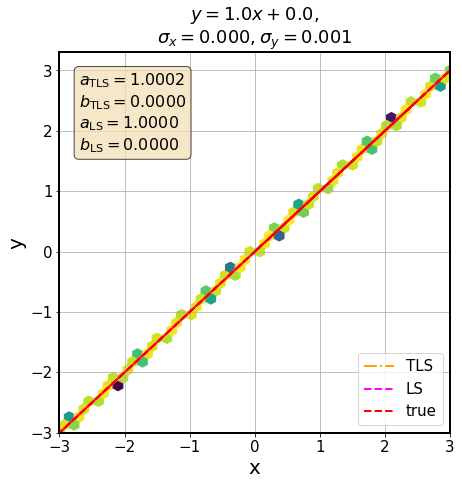

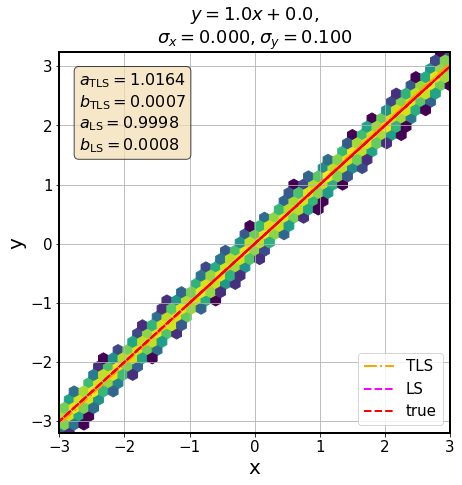

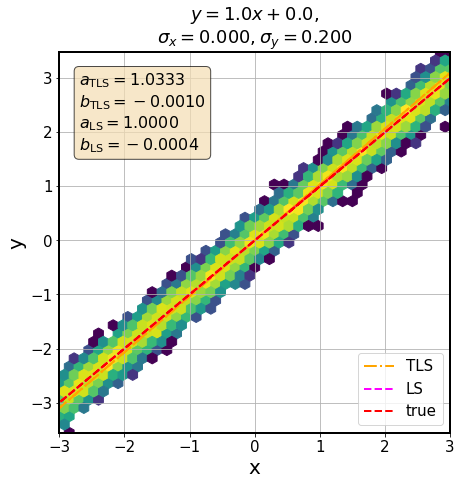

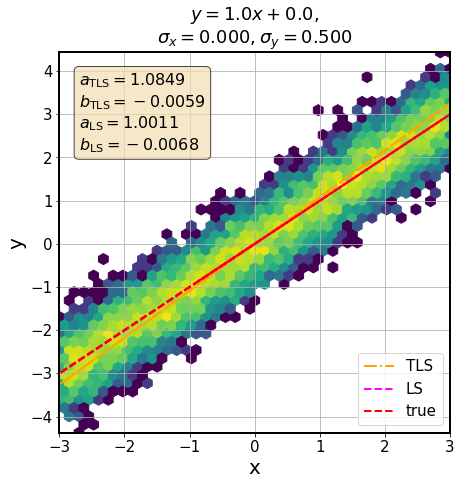

In [100]:
for sigma_y in [0.001, 0.1,0.2,0.5]:
    test_slope(a = 1, b=0, sigma_x=0, sigma_y =sigma_y, fitTLS=True, fitLS=True,
              test_num=1)

-- here I would have thought that TLS and LS should yield identical answers, because TLS reduces to LS for $\sigma_{x} = 0 $. ... 
-- I don't know why this is the case : I'm, using `curve_fit` https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html  to do the LS fitting, assuming the model of $ y = ax + b $ .... 

**Test 2**: symmetrical errors  -  set $\sigma_{x} = \sigma_{y} = \{0.001, 0.1, 0.2, 0.5 \}$

TLS offset 0.00001, slope 1.00001  
TLS offset -0.00018, slope 0.99992  
TLS offset 0.00243, slope 0.99919  
TLS offset 0.00283, slope 1.00156  
TLS offset 0.01237, slope 1.00304  


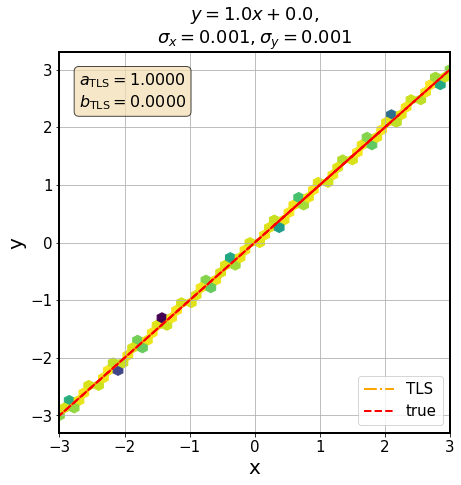

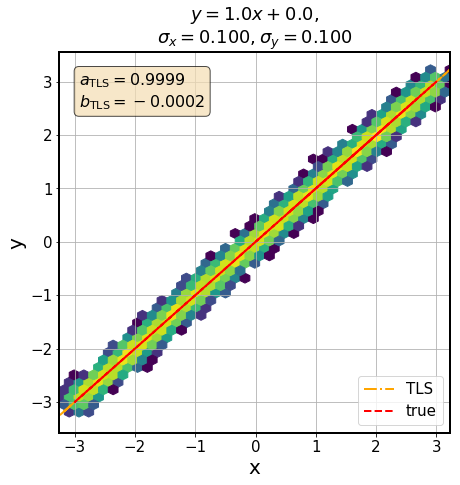

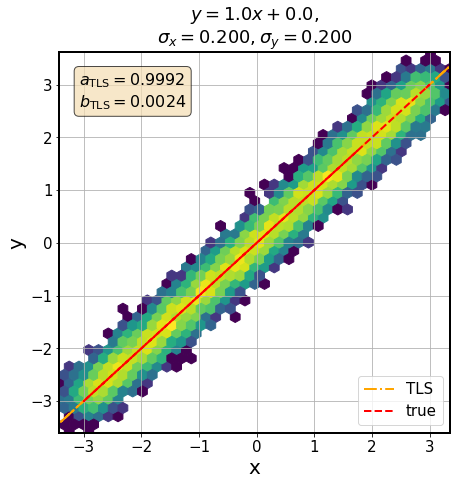

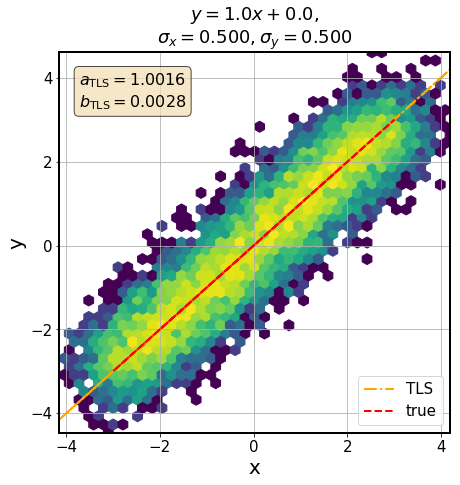

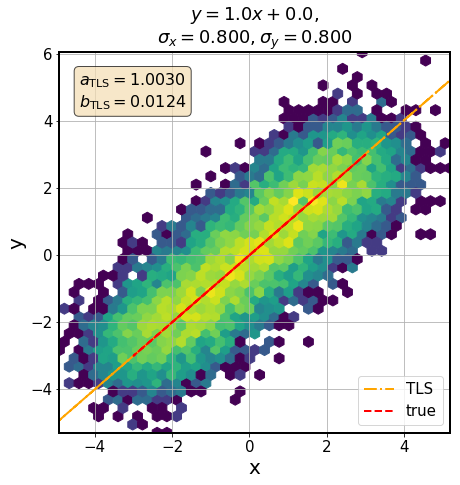

In [80]:
for sigma in [0.001, 0.1,0.2,0.5,0.8]:
    test_slope(a = 1, b=0, sigma_x=sigma, sigma_y =sigma, fitTLS=True, fitLS=False,
              test_num=2)

-- as long as the errors are symmetrical,  the recovered slope is very good .... 

**Test 3** : nonzero x error $\sigma_{x} = \{0.001,0.1, 0.2, 0.5\}$, $\sigma_{y} =  0$ 

TLS offset 0.00000, slope 0.99983  
TLS offset -0.00088, slope 0.98385  
TLS offset -0.00101, slope 0.96805  
TLS offset 0.00520, slope 0.92236  


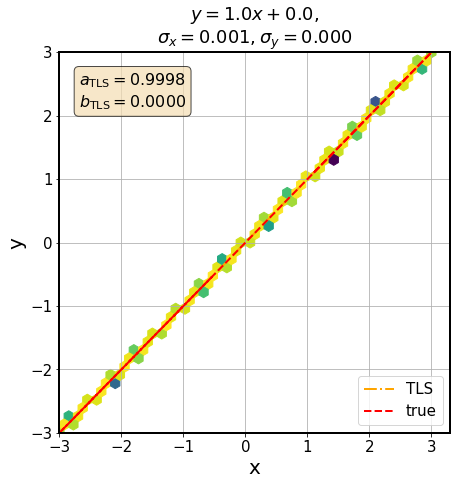

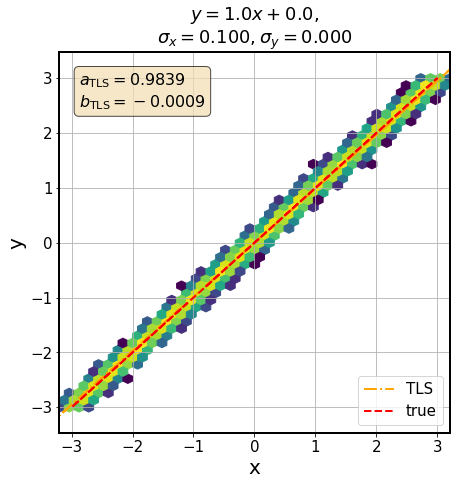

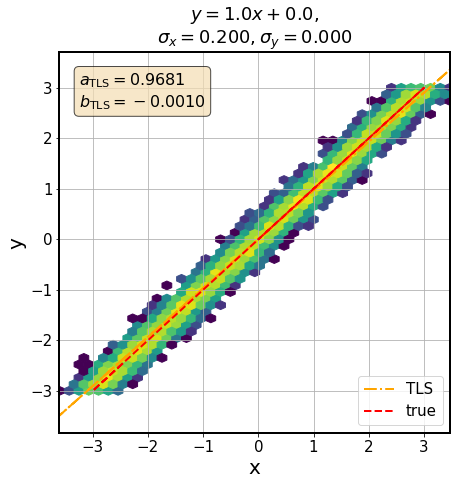

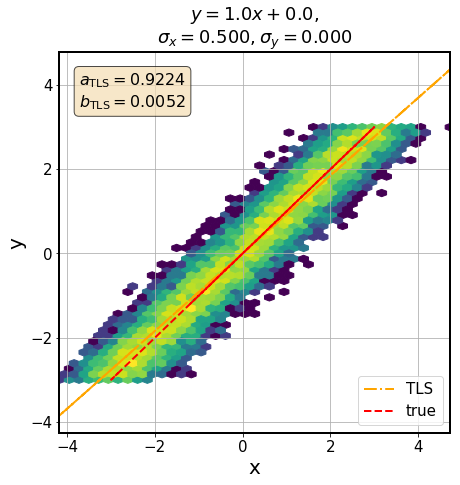

In [81]:
for sigma_x in [0.001, 0.1,0.2,0.5]:
    test_slope(a = 1, b=0, sigma_x=sigma_x, sigma_y =0, fitTLS=True, fitLS=False,
              test_num=3)

** Test 4 :** nonzero x flips to nonzero  y -- flip the axes:  only if $a=1$  the problem is symmetric : i.e  with  $\sigma_{x}=0.5$ , $\sigma_{y} = 0$, I should get the same as with $\sigma_{x}=0$, $\sigma_{y} = 0.5$, because the axes are flipped. 

TLS offset -0.00001, slope 1.00017  
LS offset -0.00001 slope 1.000005
TLS offset 0.00030, slope 1.01634  
LS offset 0.00079 slope 0.999551
TLS offset 0.00110, slope 1.03281  
LS offset 0.00018 slope 0.999585
TLS offset 0.01036, slope 1.08150  
LS offset 0.01063 slope 0.997700


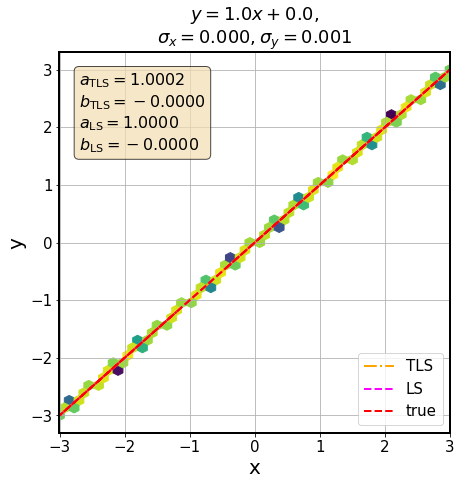

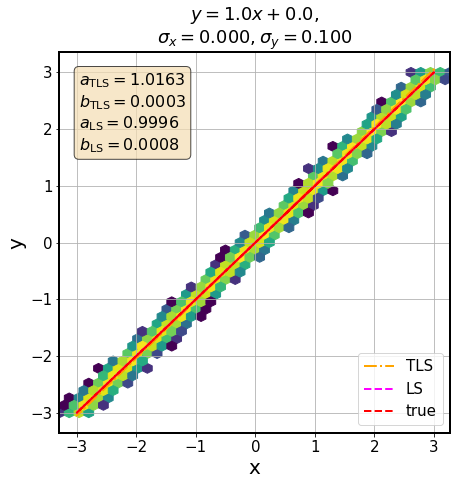

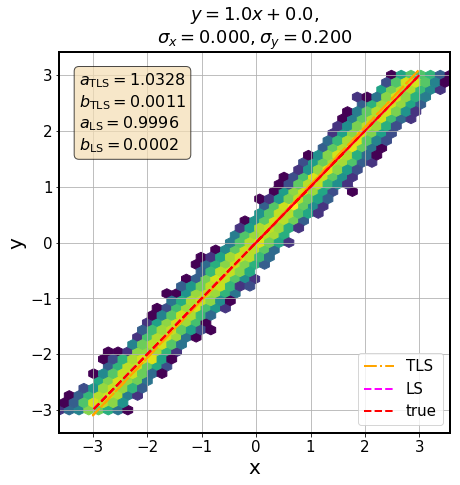

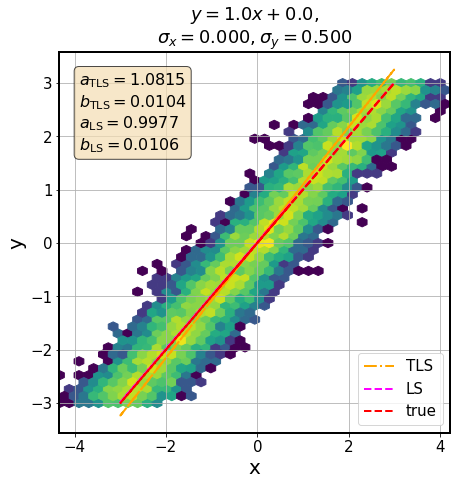

In [82]:
for sigma_x in [0.001, 0.1,0.2,0.5]:
    test_slope(a=1, b=0, sigma_x=sigma_x, sigma_y =0, fitTLS=True, fitLS=True,
               flip_axes=True, test_num=4)